Link to Medium post:[Let's talk about Signals](https://parmarsuraj99.medium.com/lets-talk-about-signals-841934f24450)

## Libraries and imports

In [ ]:
!pip install numerapi
!pip install yfinance
!pip install simplejson

!pip install catboost

     |████████████████████████████████| 5.5MB 8.1MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=c006063e49a24e3cada1f077f65529478a195ac67f39fedffb6cf0a44866256e
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 133kB 6.6MB/s 
     |████████████████████████████████| 65.7MB 90kB/s 


In [ ]:
import gc, os

import numerapi
import yfinance
import simplejson

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests
from datetime import datetime
from dateutil.relativedelta import relativedelta, FR

In [ ]:
def get_prices(tickers, threads=False, n=1000):

    chunk_df = [
            tickers.iloc[i:i+n] 
            for i in range(0, len(tickers), n)
    ]    

    concat_dfs = []

    for chunk in chunk_df:
        try:
            #['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
            
            temp_df = yfinance.download(chunk.str.cat(sep=' '),
                                        start = '2005-12-01',
                                        threads=threads)
            
            #We'll use adjusted close here
            temp_df = temp_df['Adj Close'].stack().reset_index()
            concat_dfs.append(temp_df)

        except:
            pass

    return pd.concat(concat_dfs)

Tickers that Numerai signals want. These are bloomberg tickers. yfinance asks for yahoo finance tickers.

## Data acquisition

In [ ]:
##############################################################################
########################## DOWLOAD DATA ######################################
##############################################################################

napi = numerapi.SignalsAPI()

eligible_tickers = pd.Series(napi.ticker_universe(), name="bloomberg_ticker")
print(f"Number of eligible tickers : {len(eligible_tickers)}")

print(eligible_tickers.head(10))

Number of eligible tickers : 5367
0    SVW AU
1    GEM AU
2    VOC AU
3    AZJ AU
4    MLD AU
5    NXT AU
6    TWE AU
7    SGR AU
8    CKF AU
9    BGA AU
Name: bloomberg_ticker, dtype: object


This file has mapping from bloomberg to yahoo finance tickers.
So, we can use yfinance tickers to download and then map/rename them back to bloomberg tickers.

In [ ]:
ticker_map = pd.read_csv(
        'https://numerai-signals-public-data.s3-us-west-2.amazonaws.com/signals_ticker_map_w_bbg.csv'
)
print(len(ticker_map))

ticker_map.head()

#Yahoo <-> Bloomberg mapping
yfinance_tickers = eligible_tickers.map(
        dict(zip(ticker_map["bloomberg_ticker"], ticker_map["yahoo"]))
    ).dropna()

bloomberg_tickers = ticker_map["bloomberg_ticker"]

print(f"Number of eligible, mapped tickers: {len(yfinance_tickers)}")


5031
Number of eligible, mapped tickers: 4473


These are tickers that Numerai signals wants and are also in the mapping dictionary

In [ ]:
##################### OPTION 1 ##########################

raw_data = yfinance.download(yfinance_tickers.str.cat(sep=' '), start='2005-12-01', threads=True) 
raw_data.head()
full_data = raw_data['Adj Close'].stack().reset_index()

In [ ]:
# properly position and clean raw data, after taking adjusted close only
full_data.columns = ['date', 'ticker', 'price']
full_data.set_index('date', inplace=True)

In [ ]:
# convert yahoo finance tickers back to numerai tickers
full_data['ticker'] = full_data.ticker.map(dict(zip(yfinance_tickers, numerai_tickers)))

In [ ]:
print(f"Number of tickers with data: {len(full_data.ticker.unique())}")
full_data.head()

In [ ]:
full_df = full_data

,Date,level_1,0
0,2005-12-01,000060.KS,2171.516846
1,2005-12-01,000080.KS,2002.633179
2,2005-12-01,0001.HK,31.242023
3,2005-12-01,000100.KS,20101.361328
4,2005-12-01,000120.KS,146178.234375


In [ ]:
##################### OPTION 2 ##########################

#this will take some time
full_data = get_prices(yfinance_tickers)

2021-02-28 16:43:21,631 INFO numexpr.utils: Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-02-28 16:43:21,632 INFO numexpr.utils: NumExpr defaulting to 8 threads.


[*********************100%***********************]  999 of 999 completed

21 Failed downloads:
- GENM: No data found for this date range, symbol may be delisted
- MAHB.KL: No data found, symbol may be delisted
- NESZ: No data found, symbol may be delisted
- FRCB: No data found, symbol may be delisted
- SIME: No data found, symbol may be delisted
- VSI: No data found, symbol may be delisted
- DRBM.KL: No data found, symbol may be delisted
- PETD: No data found for this date range, symbol may be delisted
- PGOLD: No data found, symbol may be delisted
- RHBC.KL: No data found, symbol may be delisted
- KRU: No data found, symbol may be delisted
- LTS: No data found, symbol may be delisted
- IHH: No data found for this date range, symbol may be delisted
- WPRTS: No data found, symbol may be delisted
- MSGB: No data found, symbol may be delisted
- PGN: No data found for this date range, symbol may be delisted
- SMPH: No data found, symbol may be delisted
- BPI: No data found, symbol may be d

,ticker,price
date,,
2005-12-01,000060 KS,2171.516846
2005-12-01,000080 KS,2002.633179
2005-12-01,1 HK,31.242023
2005-12-01,000100 KS,20101.361328
2005-12-01,000120 KS,146178.234375
...,...,...
2005-12-01,XPO US,3.000000
2005-12-01,ZBH US,59.385220
2005-12-01,ZIOP US,4.600000


In [ ]:
##############################################################################
########################## DATA WRANGLING ####################################
##############################################################################

full_df = full_data.copy()
full_df.columns=['date', 'ticker', 'price']
full_df.set_index('date', inplace=True)

In [ ]:
full_df['ticker'] = full_df.ticker.map(
    dict(zip(ticker_map["yahoo"], bloomberg_tickers))
)
full_df.to_csv("full_data.csv")

In [ ]:
#A day's data
full_df.groupby("date").get_group("2005-12-01")

In [ ]:
print(f"Number of tickers with data: {len(full_df.ticker.unique())}")

Number of tickers with data: 3447


## Technical Indicators

In [ ]:
def RSI(prices, interval=14):
    '''Computes Relative Strength Index given a price series and lookback interval
    Modified from https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
    See more here https://www.investopedia.com/terms/r/rsi.asp'''
    delta = prices.diff()

    dUp, dDown = delta.copy(), delta.copy()
    dUp[dUp < 0] = 0
    dDown[dDown > 0] = 0

    RolUp = dUp.rolling(interval).mean()
    RolDown = dDown.rolling(interval).mean().abs()

    RS = RolUp / RolDown
    RSI = 100.0 - (100.0 / (1.0 + RS))
    return RSI

def sma(prices, window=10):

    return (sum(prices, window))/window

In [ ]:
ticker_groups = full_df.groupby('ticker')
full_df["RSI"] = ticker_groups["price"].transform(lambda x: RSI(x))
full_df["SMA_10"] = ticker_groups["price"].transform(lambda x: sma(x, 10))

In [ ]:
#a list of tickers used in full_df.columns to ease the calculation.
indicators = ['RSI', 'SMA_10']

In [ ]:
full_df

,ticker,price,RSI,SMA_10
date,,,,
2005-12-01,000060 KS,2171.516846,NaN,3.587571e+06
2005-12-01,000080 KS,2002.633179,NaN,6.405638e+06
2005-12-01,1 HK,31.242023,NaN,2.237936e+04
2005-12-01,000100 KS,20101.361328,NaN,1.143060e+07
2005-12-01,000120 KS,146178.234375,NaN,5.277204e+07
...,...,...,...,...
2021-02-26,ZGNX US,21.209999,51.192132,6.198052e+03
2021-02-26,ZIOP US,5.330000,51.063829,1.751581e+03
2021-02-26,ZNGA US,11.150000,55.802462,1.048207e+03


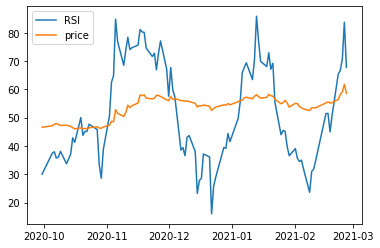

In [ ]:
plt.plot(full_df[full_df['ticker']=="1 HK"]["RSI"][-100:], label='RSI')
plt.plot(full_df[full_df['ticker']=="1 HK"]["price"][-100:], label='price')
plt.legend(loc='upper left')

plt.show()

In [ ]:
%%time

date_groups = full_df.groupby(full_df.index)

for indicator in indicators:
    print(indicator)
    full_df[f"{indicator}_quintile"] = date_groups[indicator].transform(
        lambda group: pd.qcut(group, 5, labels=False, duplicates='drop')
    ).astype(np.float32)
    gc.collect()

RSI
SMA_10
CPU times: user 1min 21s, sys: 427 ms, total: 1min 22s
Wall time: 1min 22s


In [ ]:
full_df.head()

,ticker,price,RSI,SMA_10,RSI_quintile,SMA_10_quintile
date,,,,,,
2005-12-01,000060 KS,2171.516846,NaN,3.587571e+06,NaN,4.0
2005-12-01,000080 KS,2002.633179,NaN,6.405638e+06,NaN,4.0
2005-12-01,1 HK,31.242023,NaN,2.237936e+04,NaN,3.0
2005-12-01,000100 KS,20101.361328,NaN,1.143060e+07,NaN,4.0
2005-12-01,000120 KS,146178.234375,NaN,5.277204e+07,NaN,4.0


Let's encode historical RSI into features

In [ ]:
ticker_groups = full_df.groupby("ticker")

#create lagged features, lag 0 is that day's value, lag 1 is yesterday's value, etc

for indicator in indicators:
    num_days = 5
    for day in range(num_days + 1):
        full_df[f"{indicator}_quintile_lag_{day}"] = ticker_groups[
            f"{indicator}_quintile"
        ].transform(lambda group: group.shift(day))

    gc.collect()


In [ ]:
full_df.tail()

,ticker,price,RSI,SMA_10,RSI_quintile,SMA_10_quintile,RSI_quintile_lag_0,RSI_quintile_lag_1,RSI_quintile_lag_2,RSI_quintile_lag_3,RSI_quintile_lag_4,RSI_quintile_lag_5,SMA_10_quintile_lag_0,SMA_10_quintile_lag_1,SMA_10_quintile_lag_2,SMA_10_quintile_lag_3,SMA_10_quintile_lag_4,SMA_10_quintile_lag_5
date,,,,,,,,,,,,,,,,,,
2021-02-26,ZGNX US,21.209999,51.192132,6198.052004,2.0,1.0,2.0,3.0,3.0,4.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-02-26,ZIOP US,5.330000,51.063829,1751.580999,2.0,0.0,2.0,2.0,2.0,2.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-02-26,ZNGA US,11.150000,55.802462,1048.207001,3.0,0.0,3.0,3.0,2.0,3.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-02-26,ZUMZ US,45.080002,45.806913,9363.216504,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2021-02-26,ZYXI US,14.520000,29.487185,881.546568,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# create difference of the lagged features (change in RSI quintile by day)
for indicator in indicators:
    for day in range(num_days):
        full_df[f"{indicator}_diff_{day}"] = (
            full_df[f"{indicator}_quintile_lag_{day}"]
            - full_df[f"{indicator}_quintile_lag_{day + 1}"]
        )
        full_df[f"{indicator}_abs_diff_{day}"] = np.abs(
            full_df[f"{indicator}_quintile_lag_{day}"]
            - full_df[f"{indicator}_quintile_lag_{day + 1}"]
        )

    gc.collect()


In [ ]:
full_df.tail()

,ticker,price,RSI,SMA_10,RSI_quintile,SMA_10_quintile,RSI_quintile_lag_0,RSI_quintile_lag_1,RSI_quintile_lag_2,RSI_quintile_lag_3,RSI_quintile_lag_4,RSI_quintile_lag_5,SMA_10_quintile_lag_0,SMA_10_quintile_lag_1,SMA_10_quintile_lag_2,SMA_10_quintile_lag_3,SMA_10_quintile_lag_4,SMA_10_quintile_lag_5,RSI_diff_0,RSI_abs_diff_0,RSI_diff_1,RSI_abs_diff_1,RSI_diff_2,RSI_abs_diff_2,RSI_diff_3,RSI_abs_diff_3,RSI_diff_4,RSI_abs_diff_4,SMA_10_diff_0,SMA_10_abs_diff_0,SMA_10_diff_1,SMA_10_abs_diff_1,SMA_10_diff_2,SMA_10_abs_diff_2,SMA_10_diff_3,SMA_10_abs_diff_3,SMA_10_diff_4,SMA_10_abs_diff_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-26,ZGNX US,21.209999,51.192132,6198.052004,2.0,1.0,2.0,3.0,3.0,4.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-02-26,ZIOP US,5.330000,51.063829,1751.580999,2.0,0.0,2.0,2.0,2.0,2.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-02-26,ZNGA US,11.150000,55.802462,1048.207001,3.0,0.0,3.0,3.0,2.0,3.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,1.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-02-26,ZUMZ US,45.080002,45.806913,9363.216504,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-02-26,ZYXI US,14.520000,29.487185,881.546568,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
full_df[full_df["ticker"]=="ZEL NZ"]

,ticker,price,RSI,SMA_10,RSI_quintile,SMA_10_quintile,RSI_quintile_lag_0,RSI_quintile_lag_1,RSI_quintile_lag_2,RSI_quintile_lag_3,RSI_quintile_lag_4,RSI_quintile_lag_5,SMA_10_quintile_lag_0,SMA_10_quintile_lag_1,SMA_10_quintile_lag_2,SMA_10_quintile_lag_3,SMA_10_quintile_lag_4,SMA_10_quintile_lag_5,RSI_diff_0,RSI_abs_diff_0,RSI_diff_1,RSI_abs_diff_1,RSI_diff_2,RSI_abs_diff_2,RSI_diff_3,RSI_abs_diff_3,RSI_diff_4,RSI_abs_diff_4,SMA_10_diff_0,SMA_10_abs_diff_0,SMA_10_diff_1,SMA_10_abs_diff_1,SMA_10_diff_2,SMA_10_abs_diff_2,SMA_10_diff_3,SMA_10_abs_diff_3,SMA_10_diff_4,SMA_10_abs_diff_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-08-19,ZEL NZ,2.634545,NaN,922.285286,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-20,ZEL NZ,2.692130,NaN,922.285286,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-21,ZEL NZ,2.728122,NaN,922.285286,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-22,ZEL NZ,2.720923,NaN,922.285286,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2013-08-23,ZEL NZ,2.713725,NaN,922.285286,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-22,ZEL NZ,2.740000,27.999987,922.285286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-02-23,ZEL NZ,2.740000,31.111095,922.285286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-02-24,ZEL NZ,2.690000,31.111111,922.285286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
feature_names = [f for f in full_df.columns for y in ['lag', 'diff'] if y in f]

## Historical Numerai Targets

In [ ]:
TARGET_NAME = "target"
PREDICTION_NAME = "signal"

In [ ]:
url = "https://numerai-signals-public-data.s3-us-west-2.amazonaws.com/signals_train_val.csv"
targets = pd.read_csv(url)
targets.head()

,ticker,friday_date,data_type,target
0,000270 KS,20030131,train,0.50
1,000810 KS,20030131,train,0.50
2,000830 KS,20030131,train,0.50
3,002790 KS,20030131,train,0.25
4,003450 KS,20030131,train,0.25


In [ ]:
targets['date'] = pd.to_datetime(targets['friday_date'], format='%Y%m%d')

In [ ]:
targets[targets["data_type"]=="train"]

,ticker,friday_date,data_type,target,date
0,000270 KS,20030131,train,0.50,2003-01-31
1,000810 KS,20030131,train,0.50,2003-01-31
2,000830 KS,20030131,train,0.50,2003-01-31
3,002790 KS,20030131,train,0.25,2003-01-31
4,003450 KS,20030131,train,0.25,2003-01-31
...,...,...,...,...,...
2170328,ZOLT,20121228,train,0.25,2012-12-28
2170329,ZOT SM,20121228,train,0.50,2012-12-28
2170330,ZQK,20121228,train,1.00,2012-12-28
2170331,ZUMZ,20121228,train,0.75,2012-12-28


In [ ]:
targets[targets["data_type"]=="validation"]

,ticker,friday_date,data_type,target,date
2170333,000030 KS,20130104,validation,0.25,2013-01-04
2170334,000060 KS,20130104,validation,1.00,2013-01-04
2170335,000080 KS,20130104,validation,0.75,2013-01-04
2170336,000100 KS,20130104,validation,0.50,2013-01-04
2170337,000120 KS,20130104,validation,0.75,2013-01-04
...,...,...,...,...,...
4043430,ZTS,20200228,validation,0.50,2020-02-28
4043431,ZUMZ,20200228,validation,1.00,2020-02-28
4043432,ZUO,20200228,validation,0.25,2020-02-28
4043433,ZURN SW,20200228,validation,0.25,2020-02-28


In [ ]:
targets.target.value_counts()

0.50    2024820
0.25     807654
0.75     807475
1.00     201771
0.00     201715
Name: target, dtype: int64

In [ ]:
ML_data = pd.merge(full_df.reset_index(), targets,
         on=["date", "ticker"]).set_index("date")

ML_data.dropna(inplace=True)
ML_data = ML_data[ML_data.index.weekday==4]
ML_data = ML_data[ML_data.index.value_counts() > 200]

gc.collect()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


430

In [ ]:
print(f'Number of eras in data: {len(ML_data.index.unique())}')

Number of eras in data: 726


In [ ]:
ML_data

,ticker,price,RSI,SMA_10,RSI_quintile,SMA_10_quintile,RSI_quintile_lag_0,RSI_quintile_lag_1,RSI_quintile_lag_2,RSI_quintile_lag_3,RSI_quintile_lag_4,RSI_quintile_lag_5,SMA_10_quintile_lag_0,SMA_10_quintile_lag_1,SMA_10_quintile_lag_2,SMA_10_quintile_lag_3,SMA_10_quintile_lag_4,SMA_10_quintile_lag_5,RSI_diff_0,RSI_abs_diff_0,RSI_diff_1,RSI_abs_diff_1,RSI_diff_2,RSI_abs_diff_2,RSI_diff_3,RSI_abs_diff_3,RSI_diff_4,RSI_abs_diff_4,SMA_10_diff_0,SMA_10_abs_diff_0,SMA_10_diff_1,SMA_10_abs_diff_1,SMA_10_diff_2,SMA_10_abs_diff_2,SMA_10_diff_3,SMA_10_abs_diff_3,SMA_10_diff_4,SMA_10_abs_diff_4,friday_date,data_type,target
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-12-30,1 HK,30.476746,52.999856,22379.358204,2.0,3.0,2.0,1.0,2.0,1.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,-1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20051230,train,0.75
2005-12-30,2 HK,24.614351,39.130540,19108.759726,1.0,3.0,1.0,0.0,2.0,1.0,1.0,1.0,3.0,2.0,2.0,3.0,2.0,2.0,1.0,1.0,-2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-1.0,1.0,1.0,1.0,0.0,0.0,20051230,train,0.50
2005-12-30,3 HK,3.712072,52.000183,3090.461847,2.0,0.0,2.0,2.0,3.0,4.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20051230,train,0.75
2005-12-30,4 HK,2.449564,63.999949,3915.603455,4.0,0.0,4.0,2.0,2.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20051230,train,0.75
2005-12-30,6 HK,15.974404,59.615955,13171.798932,3.0,2.0,3.0,3.0,4.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,-1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20051230,train,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-28,BBAJIOO MF,30.700001,50.777203,2998.532292,4.0,1.0,4.0,3.0,3.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,2.0,2.0,-1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,-1.0,1.0,0.0,0.0,20200228,validation,0.75
2020-02-28,CUERVO* MF,29.555410,20.913331,3306.904461,1.0,1.0,1.0,2.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20200228,validation,0.50
2020-02-28,GCC* MF,97.172020,52.732310,21789.329703,4.0,3.0,4.0,4.0,4.0,4.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20200228,validation,0.25


In [ ]:
gc.collect()

88

## Modelling

In [ ]:
##############################################################################
#######################    TRAIN MODEL    ####################################
##############################################################################

train_data = ML_data[ML_data['data_type'] == 'train']
test_data = ML_data[ML_data['data_type'] == 'validation']
gc.collect()

129

In [ ]:
feature_names = [f for f in train_data.columns for y in ['lag', 'diff'] if y in f]

In [ ]:
from catboost import CatBoost

In [ ]:
params = {
    "objective":"RMSE",
    "iterations":1000
}
model = CatBoost(params)

In [ ]:
gc.collect()

model.fit(train_data[feature_names], 
          train_data[TARGET_NAME],
          eval_set = (test_data[feature_names], 
          test_data[TARGET_NAME]))

gc.collect()

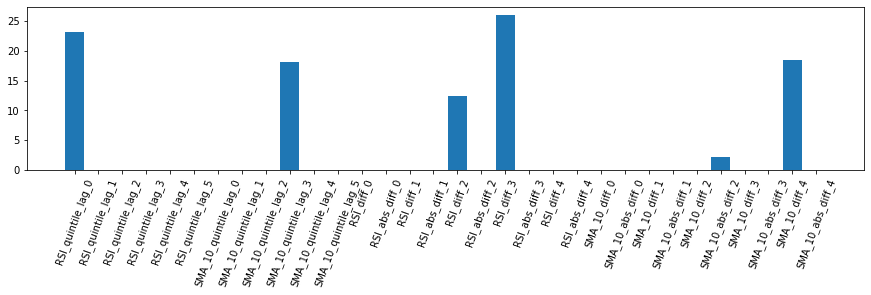

In [ ]:
plt.figure(figsize=(15,3))
plt.bar(feature_names, model.feature_importances_)
plt.xticks(rotation=70)
plt.show()

## Evaluation on historic data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


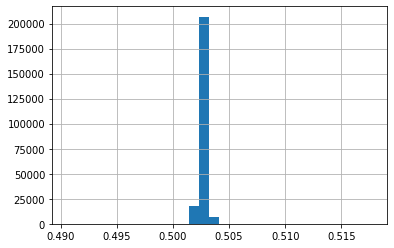

In [ ]:
##############################################################################
############################ EVALUATION ######################################
##############################################################################

train_data[PREDICTION_NAME] = model.predict(train_data[feature_names])
test_data[PREDICTION_NAME] = model.predict(test_data[feature_names])

#show prediction distribution, most should around the center
test_data[PREDICTION_NAME].hist(bins=30)

In [ ]:
#From Jason Rosenfeld's notebook
#https://twitter.com/jrosenfeld13/status/1315749231387443202?s=20

def score(df):
    '''Takes df and calculates spearm correlation from pre-defined cols'''
    # method="first" breaks ties based on order in array
    return np.corrcoef(
        df[TARGET_NAME],
        df[PREDICTION_NAME].rank(pct=True, method="first")
    )[0,1]

def run_analytics(era_scores):
    print(f"Mean Correlation: {era_scores.mean():.4f}")
    print(f"Median Correlation: {era_scores.median():.4f}")
    print(f"Standard Deviation: {era_scores.std():.4f}")
    print('\n')
    print(f"Mean Pseudo-Sharpe: {era_scores.mean()/era_scores.std():.4f}")
    print(f"Median Pseudo-Sharpe: {era_scores.median()/era_scores.std():.4f}")
    print('\n')
    print(f'Hit Rate (% positive eras): {era_scores.apply(lambda x: np.sign(x)).value_counts()[1]/len(era_scores):.2%}')

    era_scores.rolling(10).mean().plot(kind='line', title='Rolling Per Era Correlation Mean', figsize=(15,4))
    plt.axhline(y=0.0, color="r", linestyle="--"); plt.show()

    era_scores.cumsum().plot(title='Cumulative Sum of Era Scores', figsize=(15,4))
    plt.axhline(y=0.0, color="r", linestyle="--"); plt.show()

In [ ]:
# spearman scores by era
train_era_scores = train_data.groupby(train_data.index).apply(score)
test_era_scores = test_data.groupby(test_data.index).apply(score)

Mean Correlation: 0.0126
Median Correlation: 0.0144
Standard Deviation: 0.0545


Mean Pseudo-Sharpe: 0.2319
Median Pseudo-Sharpe: 0.2652


Hit Rate (% positive eras): 58.99%


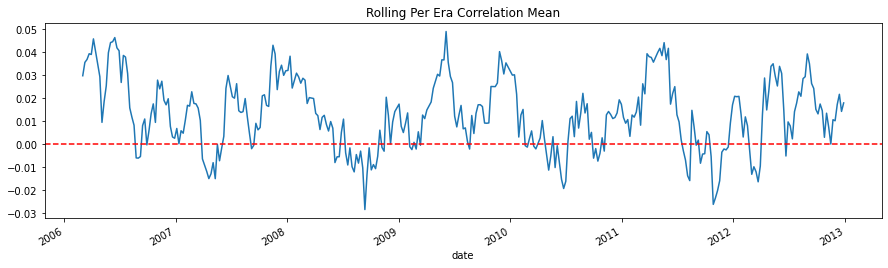

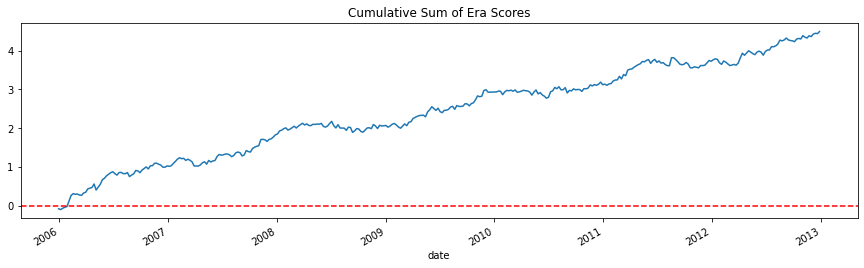

In [ ]:
#train scores, in-sample and will be significantly overfit
run_analytics(train_era_scores)

Mean Correlation: 0.0042
Median Correlation: 0.0031
Standard Deviation: 0.0459


Mean Pseudo-Sharpe: 0.0914
Median Pseudo-Sharpe: 0.0683


Hit Rate (% positive eras): 52.97%


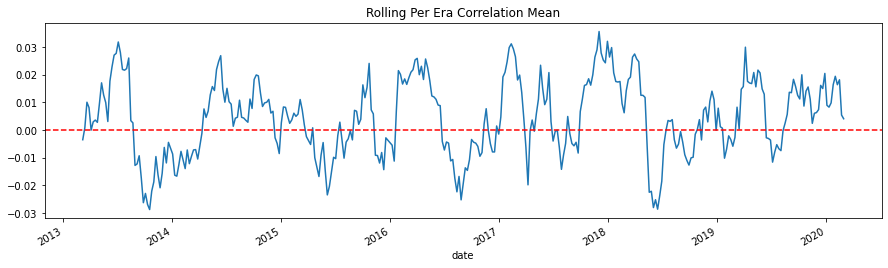

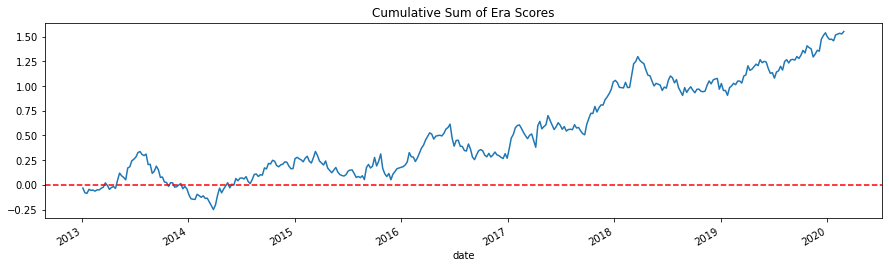

In [ ]:
#test scores, out of sample
run_analytics(test_era_scores)

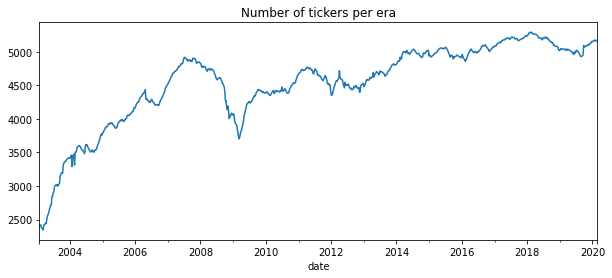

In [ ]:
# the number of tickers per era has generally increased
targets.groupby('date').apply(lambda x: len(x)).plot(kind='line', figsize=(10,4), title='Number of tickers per era')

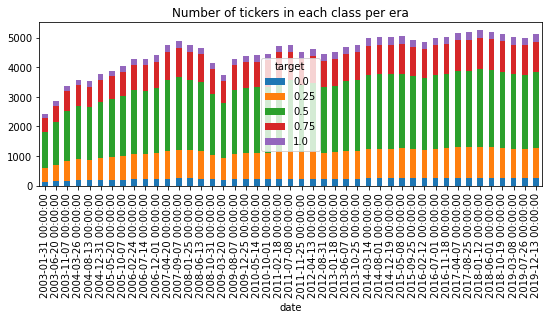

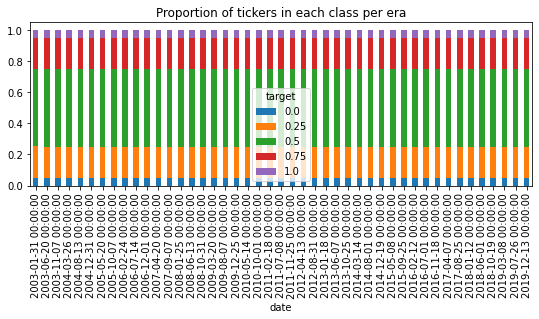

In [ ]:
# the imbalance is consistent across eras with a constant class ratio of: 5%, 20%, 50%, 20%, 5%
pivot_target = targets.groupby(['date','target']).apply(lambda x: len(x)).reset_index(1).pivot(columns='target',values=0)
pivot_target.iloc[::20].plot(kind='bar', stacked=True, figsize=(9,3), title='Number of tickers in each class per era')

stacked_data = pivot_target.apply(lambda x: x/sum(x), axis=1)
stacked_data.iloc[::20].plot(kind='bar', stacked=True, figsize=(9,3), title='Proportion of tickers in each class per era')

## Prediction on live data

In [ ]:
##############################################################################
###################  PREDICT AND SUBMIT ON LIVE DATA  ########################
##############################################################################

# choose data as of most recent friday
last_friday = datetime.now() + relativedelta(weekday=FR(-1))
date_string = last_friday.strftime('%Y-%m-%d')

live_data = full_df.loc[date_string].copy()
live_data.dropna(subset=feature_names, inplace=True)

In [ ]:
live_data

,ticker,price,RSI,SMA_10,RSI_quintile,SMA_10_quintile,RSI_quintile_lag_0,RSI_quintile_lag_1,RSI_quintile_lag_2,RSI_quintile_lag_3,RSI_quintile_lag_4,RSI_quintile_lag_5,SMA_10_quintile_lag_0,SMA_10_quintile_lag_1,SMA_10_quintile_lag_2,SMA_10_quintile_lag_3,SMA_10_quintile_lag_4,SMA_10_quintile_lag_5,RSI_diff_0,RSI_abs_diff_0,RSI_diff_1,RSI_abs_diff_1,RSI_diff_2,RSI_abs_diff_2,RSI_diff_3,RSI_abs_diff_3,RSI_diff_4,RSI_abs_diff_4,SMA_10_diff_0,SMA_10_abs_diff_0,SMA_10_diff_1,SMA_10_abs_diff_1,SMA_10_diff_2,SMA_10_abs_diff_2,SMA_10_diff_3,SMA_10_abs_diff_3,SMA_10_diff_4,SMA_10_abs_diff_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-26,000060 KS,16100.000000,76.271186,3.587571e+06,4.0,4.0,4.0,4.0,2.0,3.0,1.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,2.0,2.0,-1.0,1.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-02-26,000080 KS,34250.000000,59.195402,6.405638e+06,3.0,4.0,3.0,3.0,2.0,2.0,2.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-02-26,1 HK,58.599998,67.708326,2.237936e+04,4.0,3.0,4.0,4.0,3.0,3.0,3.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-02-26,000100 KS,62000.000000,34.782609,1.143060e+07,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-02-26,000120 KS,164000.000000,20.481928,5.277204e+07,0.0,4.0,0.0,0.0,1.0,1.0,1.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-26,ZGNX US,21.209999,51.192132,6.198052e+03,2.0,1.0,2.0,3.0,3.0,4.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-02-26,ZIOP US,5.330000,51.063829,1.751581e+03,2.0,0.0,2.0,2.0,2.0,2.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-02-26,ZNGA US,11.150000,55.802462,1.048207e+03,3.0,0.0,3.0,3.0,2.0,3.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,1.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(f"Number of live tickers to submit: {len(live_data)}")
live_data[PREDICTION_NAME] = model.predict(live_data[feature_names])

Number of live tickers to submit: 3395


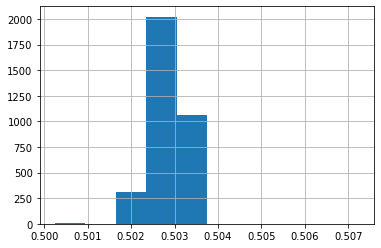

In [ ]:
live_data[PREDICTION_NAME].hist()

You can simply run this without any modification

In [ ]:
diagnostic_df = pd.concat([test_data, live_data])
diagnostic_df['friday_date'] = diagnostic_df.friday_date.fillna(
    last_friday.strftime('%Y%m%d')).astype(int)
diagnostic_df['data_type'] = diagnostic_df.data_type.fillna('live')
diagnostic_df[['ticker', 'friday_date', 'data_type',
                'signal']].reset_index(drop=True).to_csv(
    'example_signal_upload.csv', index=False)
print(
    'Example submission completed. Upload to signals.numer.ai for scores and live submission'
)

Example submission completed. Upload to signals.numer.ai for scores and live submission


In [ ]:
diagnostic_df

,ticker,price,RSI,SMA_10,RSI_quintile,SMA_10_quintile,RSI_quintile_lag_0,RSI_quintile_lag_1,RSI_quintile_lag_2,RSI_quintile_lag_3,RSI_quintile_lag_4,RSI_quintile_lag_5,SMA_10_quintile_lag_0,SMA_10_quintile_lag_1,SMA_10_quintile_lag_2,SMA_10_quintile_lag_3,SMA_10_quintile_lag_4,SMA_10_quintile_lag_5,RSI_diff_0,RSI_abs_diff_0,RSI_diff_1,RSI_abs_diff_1,RSI_diff_2,RSI_abs_diff_2,RSI_diff_3,RSI_abs_diff_3,RSI_diff_4,RSI_abs_diff_4,SMA_10_diff_0,SMA_10_abs_diff_0,SMA_10_diff_1,SMA_10_abs_diff_1,SMA_10_diff_2,SMA_10_abs_diff_2,SMA_10_diff_3,SMA_10_abs_diff_3,SMA_10_diff_4,SMA_10_abs_diff_4,friday_date,data_type,target,signal
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-04,000060 KS,8892.044922,37.179482,3.587571e+06,0.0,4.0,0.0,0.0,0.0,2.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,-2.0,2.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20130104,validation,1.00,0.503179
2013-01-04,000080 KS,23968.708984,86.268816,6.405638e+06,4.0,4.0,4.0,4.0,4.0,3.0,2.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20130104,validation,0.75,0.502557
2013-01-04,1 HK,59.667854,57.594890,2.237936e+04,1.0,3.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20130104,validation,0.50,0.503179
2013-01-04,000100 KS,26654.396484,68.060724,1.143060e+07,2.0,4.0,2.0,1.0,1.0,2.0,2.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,1.0,0.0,0.0,-1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20130104,validation,0.50,0.503179
2013-01-04,000120 KS,107500.000000,68.115942,5.277204e+07,2.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20130104,validation,0.75,0.503179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-26,ZGNX US,21.209999,51.192132,6.198052e+03,2.0,1.0,2.0,3.0,3.0,4.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20210226,live,NaN,0.502954
2021-02-26,ZIOP US,5.330000,51.063829,1.751581e+03,2.0,0.0,2.0,2.0,2.0,2.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20210226,live,NaN,0.502954
2021-02-26,ZNGA US,11.150000,55.802462,1.048207e+03,3.0,0.0,3.0,3.0,2.0,3.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,1.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20210226,live,NaN,0.502954


In [ ]:
ps = diagnostic_df.groupby('date')[PREDICTION_NAME].rank(pct=True, method="first")

In [ ]:
diagnostic_df["signal"] = ps

In [ ]:
diagnostic_df[["ticker", "friday_date", "data_type", "signal"]].reset_index(
    drop=True
).to_csv("example_signal_upload.csv", index=False)

print("Upload to signals.numer.ai for scores and live submission")

Upload to signals.numer.ai for scores and live submission


## Uploading predictions using your API keys 🚀

Find your Numerapi public and private keys from https://numer.ai/account

In [ ]:
##############################################################################
######################### MAKE SUBMISSION #################################### 
##############################################################################

To create a key for submission only, 

`Settings -> Create API key -> select "Upload Predictions" -> Save`


In [ ]:
# NameOfYourAI
# Add keys between the quotes
public_id = "7TISUDGAWEVO2B35ECOQQXU2RWXGZN3I"
secret_key = "QJYUWIMFEEDNZ4GHUO6VSSKPMRCBFJIMJ7BZ65ESIWRN4YHGYHSRJDNL64TAG7EH"
model_id = "d49c26a4-aa5b-4490-9d58-300c5e05d996"
napi = numerapi.SignalsAPI(public_id=public_id, secret_key=secret_key)

In [ ]:
submission_id = napi.upload_predictions(f"/content/example_signal_upload.csv", model_id=model_id)

2021-02-28 17:15:23,649 INFO numerapi.base_api: uploading predictions...
